In [24]:
import os
from typing import TypedDict, Annotated, List
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
import operator
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from dotenv import load_dotenv

In [25]:
load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")

In [26]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

In [27]:
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000242FBD249D0>, default_metadata=(), model_kwargs={})

In [28]:
# meminta rekomendasi: kuliner / destinasi
# diarahkan ke agent spesifik sesuai rekomendasi

In [29]:
class TravelState(TypedDict):
    user_request: str
    intent: str
    recommendation: str
    messages: Annotated[List[AnyMessage], operator.add]

In [30]:
def intent_classifier_node(state: TravelState) -> TravelState:
    print("Menentukan intent dari user_request...")

    user_request = state["user_request"]

    prompt = f"""Tentukan apakah permintaan berikut berhubungan dengan 'kuliner' atau 'destinasi' wisata:
    '{user_request}'
    Berikan jawaban hanya dengan satu kata: 'kuliner' atau 'destinasi'.
    """

    response = llm.invoke(prompt)
    intent = response.content.strip().lower()

    # memberikan skenario jika pertanyaan di luar kuliner atau destinasi

    state["intent"] = intent
    return state

In [31]:
def intent_router(state: TravelState):
    print("Merouting ke agen yang sesuai berdasarkan intent...")
    
    intent = state["intent"]
    print(f"Routing ke agen berdasarkan intent: {intent}")
    if intent == "kuliner":
        return "culinary_agent"
    elif intent == "destinasi":
        return "destination_agent"

In [32]:
def culinary_agent(state: TravelState) -> TravelState:
    print("Menjalankan Culinary Agent...")
    
    user_request = state["user_request"]
    
    # digunakan untuk mengupdate messages
    messages = state["messages"]

    prompt = f"""Anda adalah asisten perjalanan yang ahli dalam memberikan rekomendasi kuliner. berikan rekomendasi kuliner berdasarkan permintaan berikut:
    '{user_request}'
    """

    response = llm.invoke(prompt)
    recommendation = response.content

    state["recommendation"] = recommendation
    state["messages"] = messages + [HumanMessage(content=user_request), response]

    return state

In [33]:
def destination_agent(state: TravelState) -> TravelState:
    print("Menjalankan Destination Agent...")
    
    user_request = state["user_request"]
    
    # digunakan untuk mengupdate messages
    messages = state["messages"]

    prompt = f"""Anda adalah asisten perjalanan yang ahli dalam memberikan rekomendasi destinasi wisata. berikan rekomendasi destinasi wisata berdasarkan permintaan berikut:
    '{user_request}'
    """

    response = llm.invoke(prompt)
    recommendation = response.content

    state["recommendation"] = recommendation
    state["messages"] = messages + [HumanMessage(content=user_request), response]

    return state

In [34]:
workflow = StateGraph(TravelState)

workflow.add_node("intent_classifier", intent_classifier_node)
workflow.add_node("culinary_agent", culinary_agent)
workflow.add_node("destination_agent", destination_agent)

workflow.add_edge(START, "intent_classifier")
workflow.add_conditional_edges(
    "intent_classifier",
    intent_router,
    {
        "culinary_agent": "culinary_agent",
        "destination_agent": "destination_agent",
    })

workflow.add_edge("culinary_agent", END)
workflow.add_edge("destination_agent", END)

app = workflow.compile()

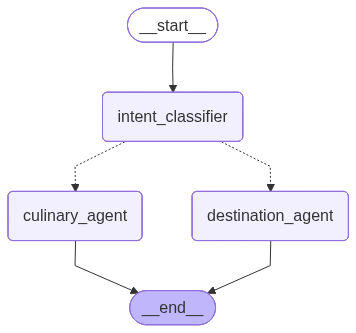

In [35]:
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
user_request = "Rekomendasikan tempat makan enak di Bali"

initial_state: TravelState = {
    "user_request": user_request,
    "messages": [HumanMessage(content=user_request)],
}

result = app.invoke(initial_state)

result

Menentukan intent dari user_request...
Merouting ke agen yang sesuai berdasarkan intent...
Routing ke agen berdasarkan intent: kuliner
Menjalankan Culinary Agent...


{'user_request': 'Rekomendasikan tempat makan enak di Bali',
 'intent': 'kuliner',
 'recommendation': 'Baik, dengan senang hati saya akan memberikan rekomendasi tempat makan enak di Bali! Untuk memberikan rekomendasi yang paling sesuai, saya perlu sedikit informasi tambahan tentang preferensi Anda. Namun, berikut adalah beberapa rekomendasi berdasarkan kategori yang berbeda, mencakup berbagai selera dan anggaran:\n\n**Untuk Pengalaman Mewah & Pemandangan Indah:**\n\n*   **Sundara (Four Seasons Resort Bali at Jimbaran Bay):** Menyajikan hidangan modern dengan sentuhan Asia Tenggara, dengan pemandangan matahari terbenam yang spektakuler di Jimbaran Bay. Cocok untuk makan malam romantis.\n*   **Mozaic (Ubud):** Restoran fine dining legendaris di Ubud yang menggabungkan bahan-bahan lokal Bali dengan teknik memasak Prancis modern. Menawarkan pengalaman gastronomi yang tak terlupakan.\n*   **Locavore (Ubud):** Berfokus pada bahan-bahan lokal dan berkelanjutan, Locavore menawarkan menu degust

In [38]:
result['recommendation']

'Baik, dengan senang hati saya akan memberikan rekomendasi tempat makan enak di Bali! Untuk memberikan rekomendasi yang paling sesuai, saya perlu sedikit informasi tambahan tentang preferensi Anda. Namun, berikut adalah beberapa rekomendasi berdasarkan kategori yang berbeda, mencakup berbagai selera dan anggaran:\n\n**Untuk Pengalaman Mewah & Pemandangan Indah:**\n\n*   **Sundara (Four Seasons Resort Bali at Jimbaran Bay):** Menyajikan hidangan modern dengan sentuhan Asia Tenggara, dengan pemandangan matahari terbenam yang spektakuler di Jimbaran Bay. Cocok untuk makan malam romantis.\n*   **Mozaic (Ubud):** Restoran fine dining legendaris di Ubud yang menggabungkan bahan-bahan lokal Bali dengan teknik memasak Prancis modern. Menawarkan pengalaman gastronomi yang tak terlupakan.\n*   **Locavore (Ubud):** Berfokus pada bahan-bahan lokal dan berkelanjutan, Locavore menawarkan menu degustasi yang kreatif dan inovatif.\n\n**Untuk Hidangan Bali Otentik:**\n\n*   **Warung Ibu Oka (Ubud):** T